In [1]:
using Revise
using Pkg; Pkg.activate("..")

using Dates
using Interpolations
using DelimitedFiles
using CSV
using MAT
using NCDatasets
using DataFrames
#using PyPlot
using PythonPlot

using Psychrometrics
include("./VaporSat.jl")
using .VaporSat

#using PyCall
using PythonCall


  Activating project at `~/Projects/submersible_humidity_sensor`


In [ ]:
# thread experiments

# gc()            # Julia GC
pygui(false)      # Optional: disable interactive GUI if not needed
pyimport("gc").collect() # Python GC

# Only if you run julia -t 1,0 does it really use only one thread.
# using Base.Threads
# nthreads() # 1
Threads.nthreads() # Default pool number of threads
Threads.nthreads(:default) # Number of default threads
Threads.nthreads(:interactive) # Number of interactive threads
Threads.nthreads(), Threads.nthreads(:default), Threads.nthreads(:interactive)
# (1, 1, 1) # 1 default === 1 worker thread; and 1 interactive thread

# create IJulia kernel with 1 worker thread and 0 interactive threads
# using IJulia
# IJulia.installkernel("Julia (1 thread)", env=Dict("JULIA_NUM_THREADS" => "1"))


(1, 1, 1)

In [2]:
# data helper functions
md2dt(md) = DateTime(-1,12,31) + Day(floor(md)) + Millisecond(round(86_400_000*(md%1)))

m2n(x) = replace(x, missing=>NaN)

m2n (generic function with 1 method)

In [3]:
# test reading WXT MAT file
wxt = matread("../data/20251211Tank/20251208_SHS-test_EGH_WXT/processed/ASWXT203.mat")

Dict{String, Any} with 38 entries:
  "hail_accumulation"   => [0.0; 0.0; … ; 0.0; 0.0;;]
  "rain_duration"       => [0.0; 0.0; … ; 50.0; 50.0;;]
  "wnde_avg"            => [-0.0241835; 0.0570489; … ; 0.0642299; 0.0858882;;]
  "wdir_avg"            => [313.039; 103.736; … ; 63.6313; 68.5511;;]
  "hrh"                 => [16.8; 16.9; … ; 38.0; 37.9;;]
  "compass11"           => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 152.9 152…
  "bpr"                 => [1020.3; 1020.3; … ; 994.8; 994.8;;]
  "wspd_avg"            => [0.0410351; 0.0731177; … ; 0.0679381; 0.0933986;;]
  "mday"                => [7.3996e5; 7.3996e5; … ; 739962.0; 739962.0;;]
  "wspd11"              => [0.0 0.0 … 0.0 0.0; 0.1 0.1 … 0.0 0.1; … ; 0.1 0.1 ……
  "precip"              => [0.0; 0.0; … ; 0.1; 0.1;;]
  "rhtpflag"            => [0.0; 0.0; … ; 0.0; 0.0;;]
  "hail_duration"       => [0.0; 0.0; … ; 0.0; 0.0;;]
  "compass_avg"         => [0.0; 151.242; … ; 152.864; 152.839;;]
  "tilt_x"              => [-1.02727; -1.0

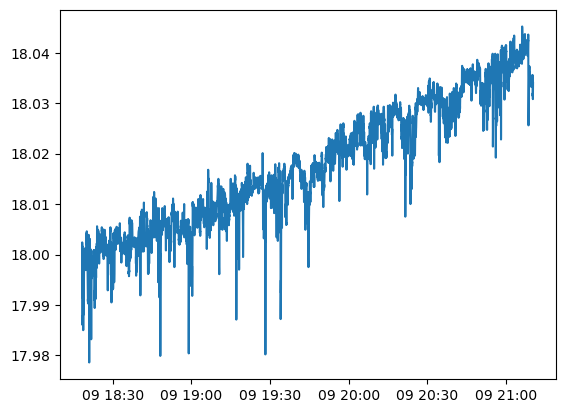

Python: [<matplotlib.lines.Line2D object at 0x34cb43770>]

In [4]:
# tank_temp = vcat(CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_Tank-Temp/20251208_SHS-test_EGH.txt", DataFrame),
#                  CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_Tank-Temp/20251209_SHS-test_EGH.txt", DataFrame))
filename = "../data/20251211Tank/20251208_SHS-test_EGH_Tank-Temp/20251209_SHS-test_EGH.txt"
# tmp = CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_Tank-Temp/20251209_SHS-test_EGH.txt", DataFrame) # includes 20251209
tmp = CSV.read(IOBuffer(replace(read(filename, String), "]"=>",")), DataFrame)
tank_temp = tmp[!,3] # second column is temperature
str2dt(s) = startswith(s, '[') ?  DateTime(strip(s, ['[', ']']), dateformat"e u dd HH:MM:SS.sss yyyy") : missing
tank_time = str2dt.(tmp[!,1]) # first column is timestamp

# close(gcf())
plot(m2n(tank_time), tank_temp, label="Tank T") # bad time axis
#gcf()

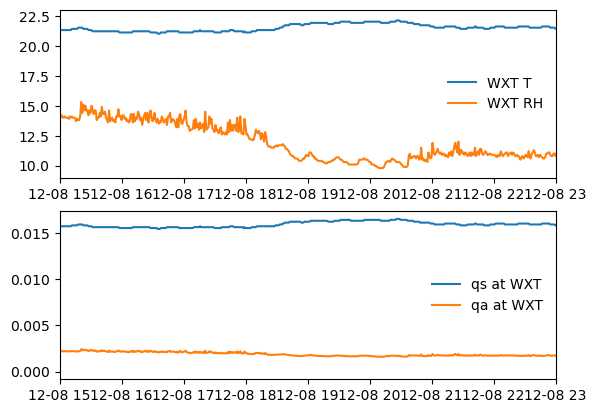

Python: (np.float64(20430.625), np.float64(20430.958333333332))

In [5]:
#plot WXT data
close(gcf())
subplot(2,1,1)
plot(md2dt.(wxt["mday"]), wxt["atmp"], label="WXT T")
plot(md2dt.(wxt["mday"]), wxt["hrh"], label="WXT RH")
legend(frameon=false)
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
ylim([9.0,23.0])
subplot(2,1,2)
plot(md2dt.(wxt["mday"]), qs.(101325.0,wxt["atmp"]), label="qs at WXT")
plot(md2dt.(wxt["mday"]), qs.(101325.0,wxt["atmp"]) .* wxt["hrh"]/100, label="qa at WXT")
legend(frameon=false)
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
# gcf()


In [6]:
wxt

Dict{String, Any} with 38 entries:
  "hail_accumulation"   => [0.0; 0.0; … ; 0.0; 0.0;;]
  "rain_duration"       => [0.0; 0.0; … ; 50.0; 50.0;;]
  "wnde_avg"            => [-0.0241835; 0.0570489; … ; 0.0642299; 0.0858882;;]
  "wdir_avg"            => [313.039; 103.736; … ; 63.6313; 68.5511;;]
  "hrh"                 => [16.8; 16.9; … ; 38.0; 37.9;;]
  "compass11"           => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 152.9 152…
  "bpr"                 => [1020.3; 1020.3; … ; 994.8; 994.8;;]
  "wspd_avg"            => [0.0410351; 0.0731177; … ; 0.0679381; 0.0933986;;]
  "mday"                => [7.3996e5; 7.3996e5; … ; 739962.0; 739962.0;;]
  "wspd11"              => [0.0 0.0 … 0.0 0.0; 0.1 0.1 … 0.0 0.1; … ; 0.1 0.1 ……
  "precip"              => [0.0; 0.0; … ; 0.1; 0.1;;]
  "rhtpflag"            => [0.0; 0.0; … ; 0.0; 0.0;;]
  "hail_duration"       => [0.0; 0.0; … ; 0.0; 0.0;;]
  "compass_avg"         => [0.0; 151.242; … ; 152.864; 152.839;;]
  "tilt_x"              => [-1.02727; -1.0

In [7]:
# test reading RBR thermistors
rbr = NCDataset("../data/20251211Tank/20251208_SHS-test_EGH_RBR/233860_20251211_1631.nc")
events_rbr = CSV.read("../data/20251211Tank/20251208_SHS-test_EGH_RBR/233860_20251211_1631_events.txt", DataFrame)
rbrT  = rbr["temperature"][:]
rbrTw = rbr["temperature1"][:] # wet bulb

529089-element Vector{Float64}:
 21.17946163460101
 21.17946163460101
 21.17946163460101
 21.178361407249156
 21.178361407249156
 21.178361407249156
 21.178361407249156
 21.177970831634525
 21.177970831634525
 21.177970831634525
 21.177970831634525
 21.17759676171778
 21.17759676171778
  ⋮
 21.16844931388988
 21.168448712313136
 21.17416423445775
 21.17416423445775
 21.17416423445775
 21.17416423445775
 21.17416423445775
 21.19134544044755
 21.19134544044755
 21.19134544044755
 21.19134544044755
 21.198944669982154

In [8]:
# calc wet bulb T from WXT
wxt_T = wxt["atmp"] # °C
wxt_p = wxt["bpr"] .* 100.0 # hPa -> Pa
wxt_qa = qs.(wxt_p,wxt_T) .* (1e-2*wxt["hrh"])
# wxt_T[8:10]       # check some values
# wxt["hrh"][8:10]  # bad values of 0.0
wxt_Tw = Twet_autodiff.(wxt_T.+273.15, wxt_qa, wxt_p; niter=2) .- 273.15
wxt_Tw[wxt["hrh"][:].==0.0 .&& wxt_T.==0.0] .= NaN # mask bad values
wxt_Tw[8:10]  # check some values

3-element Vector{Float64}:
   9.317252391493469
 NaN
   9.282808401672696

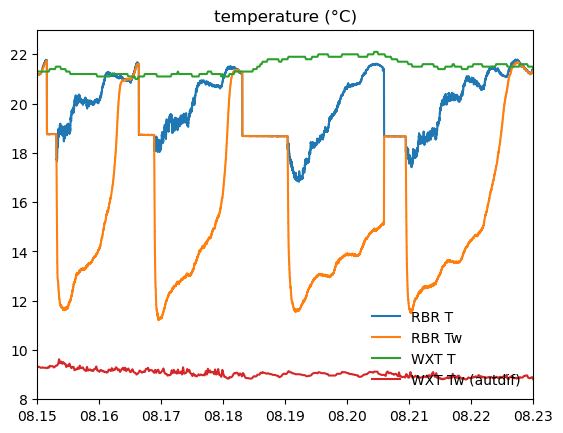

Python: None

In [12]:
# plot some temperatures of the tank test
#mdates = PyPlot.matplotlib.dates
mdates = PythonPlot.matplotlib.dates

close(gcf())
plot(rbr["time"][:], rbr["temperature"][:], label="RBR T")
plot(rbr["time"][:], rbr["temperature1"][:], label="RBR Tw") # wet bulb
plot(md2dt.(wxt["mday"]), wxt["atmp"], label="WXT T")
plot(md2dt.(wxt["mday"]), wxt_Tw, label="WXT Tw (autdif)")
#plot(md2dt.(wxt["mday"]), wxt["hrh"], label="WXT RH")
legend(frameon=false)
title("temperature (°C)")
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
ylim([8,23])
ax = gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%H"))

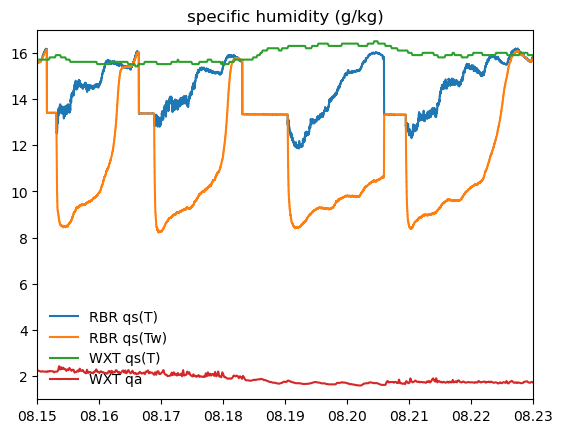

Python: None

In [13]:
# plot some specific humidities of the tank test
close(gcf())
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature"][:]), label="RBR qs(T)")
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature1"][:]), label="RBR qs(Tw)") # wet bulb
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]), label="WXT qs(T)")
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]) .* wxt["hrh"]/100, label="WXT qa")
legend(frameon=false)
title("specific humidity (g/kg)")
xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
ylim([1,17])
ax = gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%H"))
# gcf()

In [14]:
C = 273.15
maxT  = maximum(rbr["temperature"][:])
minTw = minimum(rbr["temperature1"][:])
maxT, minTw, VaporSat.qa_wb(maxT+C, minTw+C), VaporSat.qa_wb(maxT+C, minTw-1.5+C)

(22.303374736635533, 11.211056823787601, 0.0037935286153661556, 0.0023879791454498563)

$T-T_w$ should be about 1.5 $^\circ$ C larger.

In [15]:
Cp = VaporSat.Cp  # J/(kg·K)
LvC = VaporSat.LvC  # J/kg, function of T °C
qs = VaporSat.qs  # qs(p[Pa],T[C])

qs (generic function with 1 method)

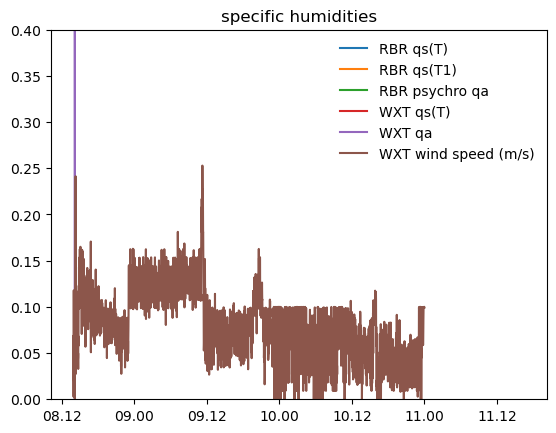

Python: (0.0, 0.4)

In [ ]:
# compute qa from T and Tw
#qsTw = VaporSat.qs(1013.25, rbr["temperature1"][:])
# qa - qs(p,Tw) = Cp/LvC(T) * (T-Tw)
q_air_fcn(T,Tw,p=101325.0) = qs(p,Tw) - Cp/LvC(T) * (T-Tw) # like qa_wb but with different default pressure
qa = q_air_fcn.(rbr["temperature"][:], rbr["temperature1"][:])

close(gcf())
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature"][:]), label="RBR qs(T)")
plot(rbr["time"][:], 1e3*qs.(101325.0,rbr["temperature1"][:]), label="RBR qs(T1)")
plot(rbr["time"][:], 1e3*qa, label="RBR psychro qa")
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]), label="WXT qs(T)")
plot(md2dt.(wxt["mday"]), 1e3*qs.(101325.0,wxt["atmp"]) .* wxt["hrh"]/100, label="WXT qa")
plot(md2dt.(wxt["mday"]), wxt["wspd"], label="WXT wind speed (m/s)")
legend(frameon=false)
title("specific humidities")
# xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,23)]) # 4 nice tests
# xlim([DateTime(2025,12,9,18), DateTime(2025,12,10,0)]) # 2 nice tests
ylim([0,17])
ax = gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%H"))
# gcf()

ax.set_ylim([0,.4]) # see wind speed

# 4 nice tests
# xlim([DateTime(2025,12,8,15), DateTime(2025,12,8,16)])

# 2 nice tests
# xlim([DateTime(2025,12,9,21), DateTime(2025,12,9,21,30)])

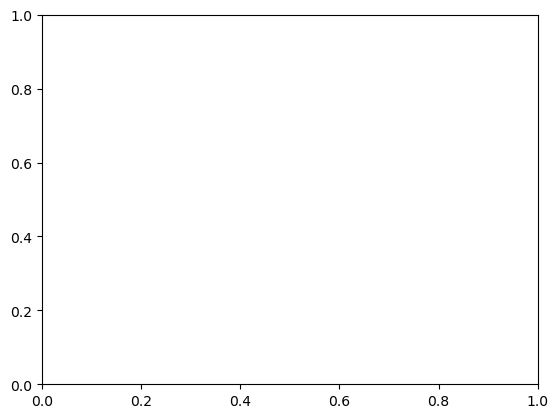

Python: <Axes: >

In [ ]:
# PythonPlot is threadsafe.
# It doesn't work to modify a plot from one cell in another.
fig = gcf() # now a blank new figure
ax = gca()
# ax.set_ylim([0,.4])

In [ ]:
qa_est = q_air_fcn.(21.3, 9.5) # 0.0024840466727118014
# T1 not measured below 11 C when WXT qa = 0.025.

0.0024840466727118014

In [31]:
spechum(W) = W/(1+W) # W is mixing ratio
qs(101325.0,12.0) # 0.00865781959506277
psychro( Tdry=12.0+273.15, φ=1.0 ).Wsat
a = psychro( Tdry=22.0+273.15, φ=0.14 )
a.Twet-273.15 # 9.500 C
q_air_fcn.(22.0, 9.5), spechum(a.W) # agree within 5%

# Air humidity is very low. 
# Wet bulb temperature 9.5 C is lower than temperature1

(0.002193490412388921, 0.0022758778368098783)

In [32]:
# clf()
# a = psychro( Tdry=20.0+273.15, Twet=12.0+273.15, fig=false)
a = psychro( Tdry=22.0+273.15, φ=0.014, fig=false)
# (
#     Tdry, # dry bulb temperature
#     Twet, # wet bulb temperature
#     Tdew, # dew point temperature
#     Tadiab, # adiabatic saturation temperature
#     W, # humidity
#     Wsat, # saturation humidity
#     Wsatwet, # saturation humidity at wet bulb temperature
#     Wadiab, # adiabatic saturation humidity
#     φ, # relative humidity
#     h, # specific enthalpy
#     v, # specific volume
#     pw, # water vapor pressure
#     psat, # saturation pressure
#     psatwet, # saturation pressure at wet bulb temperature
#     ρ # density
#     )
a.Wsat
# gca()

0.016668898521790675